In [1]:
!pip install gensim==3.8.3
!pip install keras --upgrade
!pip install pandas --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.2 MB 1.2 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 4.6 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires keras<2.10.0,>=2.9.0rc0, but you have keras 2.11.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install tf-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 551.1 MB 26 kB/s 
     |████████████████████████████████| 1.7 MB 55.6 MB/s 
     |████████████████████████████████| 439 kB 86.3 MB/s 
     |████████████████████████████████| 5.7 MB 54.4 MB/s 
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires flatbuffers<2,>=1.12, but you have flatbuffers 22.11.23 which is incompatible.
tensorflow 2.9.2 requires keras<2.10.0,>=2.9.0rc0, but you have keras 2.11.0 which is incompatible.


In [3]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 100
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [45]:
# df = pd.read_csv('/content/drive/MyDrive/Twitter/training.1600000.processed.noemoticon.csv', encoding =DATASET_ENCODING , names=DATASET_COLUMNS)
df = pd.read_csv('/content/drive/MyDrive/Twitter/training.1600000.processed.noemoticon.csv', encoding = "latin-1", low_memory=False)

In [46]:
print("Dataset size:", len(df))

Dataset size: 50000


In [47]:
print(df.columns)
print(df.head(2))

Index(['ids', 'date', 'user', 'text', 'target'], dtype='object')
          ids                          date            user  \
0  2265878782  Sun Jun 21 07:29:15 PDT 2009         MeeJong   
1  2205565064  Wed Jun 17 05:00:35 PDT 2009  kathysyahrizal   

                                                text  target  
0  This morning my daughter asked me if I hate my...       0  
1     I forgot to charge my bb, zzzzz only 35% left        0  


In [48]:
# randomly sample 25000 rows with target == 0, and 25000 rows with target == 4
neg_df = df[df.target == 0].sample(n=25000, random_state=5)
pos_df = df[df.target == 4].sample(n=25000, random_state=5)

In [49]:
neg_df.head()

,ids,date,user,text,target
12653,2298722903,Tue Jun 23 12:02:00 PDT 2009,i_live_in_a_box,because you thought they did,0
22745,1978271279,Sat May 30 22:53:08 PDT 2009,jennac0re,"@xsparkage almost every morning, actually. it ...",0
18675,2203622372,Wed Jun 17 00:09:10 PDT 2009,shoeaddictk8,"Can't sleep, watching confessions of a shopaho...",0
23488,1573555950,Tue Apr 21 01:44:00 PDT 2009,MConlon,Yay preliminary analysis is done - presentatio...,0
5580,2175942206,Mon Jun 15 02:27:00 PDT 2009,Handsets,ICC getting shirty with Voda in India http:...,0


In [50]:
pos_df.head()

,ids,date,user,text,target
37653,2002074036,Tue Jun 02 03:03:20 PDT 2009,mp3mad,@winterchick12 Thanks for following Chelsea. S...,4
47745,2010644954,Tue Jun 02 17:43:47 PDT 2009,HalfassBackward,@CodeN1Nj4 Do you got any of that ICY HOT rub?...,4
43675,2053613403,Sat Jun 06 05:09:01 PDT 2009,Julia_oliveros,@aliyoopah i thought he already have a first k...,4
48488,2047674228,Fri Jun 05 14:00:25 PDT 2009,mleis,@lwcavallucci how did you know?,4
30580,2013889095,Tue Jun 02 23:51:35 PDT 2009,supernaani,I think I'll sleep now. good night. cheeses! :...,4


In [92]:
decode_map = {0: "NEGATIVE", 2:"NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

Text(0.5, 1.0, 'Dataset labels distribuition')

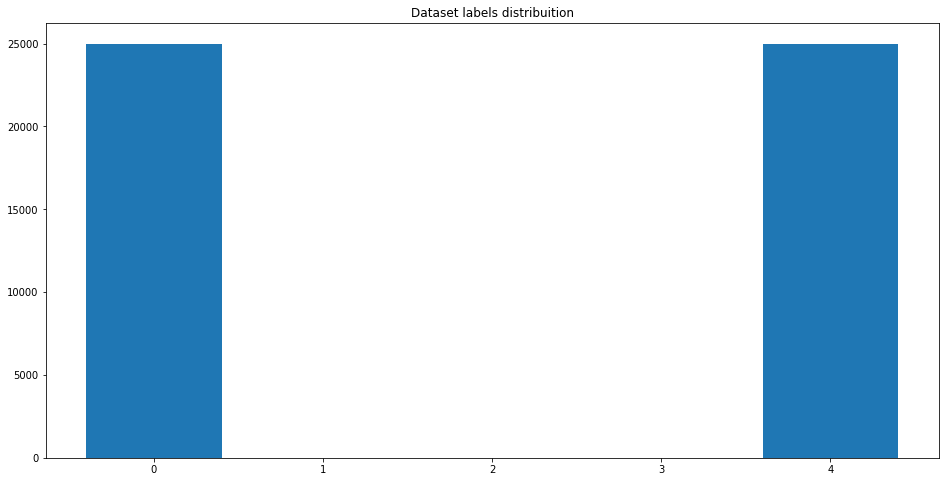

In [93]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [94]:
stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")

In [95]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [96]:
print(df.head())

          ids                          date            user  \
0  2265878782  Sun Jun 21 07:29:15 PDT 2009         MeeJong   
1  2205565064  Wed Jun 17 05:00:35 PDT 2009  kathysyahrizal   
2  2002872654  Tue Jun 02 05:22:07 PDT 2009         kgautam   
3  1835496893  Mon May 18 06:07:33 PDT 2009       thejanice   
4  1573596472  Tue Apr 21 01:55:46 PDT 2009    lucyxechelon   

                                                text  target  
0                   morning daughter asked hate life       0  
1                     forgot charge bb zzzzz 35 left       0  
2  mbp battery fluctuating dead alive amp kicking...       0  
3  really wish landlord would call back water spr...       0  
4                                   mean blog people       0  


In [97]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 1.29 s, sys: 0 ns, total: 1.29 s
Wall time: 1.29 s


In [98]:
w2v_model = gensim.models.word2vec.Word2Vec()

In [99]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 40000
TEST size: 10000


In [100]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 223 ms, sys: 1.58 ms, total: 224 ms
Wall time: 223 ms


In [101]:
w2v_model = gensim.models.word2vec.Word2Vec()

In [102]:
w2v_model.build_vocab(documents)

In [103]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 5860


In [104]:
print(w2v_model)

Word2Vec(vocab=5860, size=100, alpha=0.025)


In [105]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 17 s, sys: 0 ns, total: 17 s
Wall time: 6.12 s


(7361132, 9234176)

In [106]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 33103
CPU times: user 514 ms, sys: 0 ns, total: 514 ms
Wall time: 510 ms


In [107]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 649 ms, sys: 0 ns, total: 649 ms
Wall time: 648 ms


In [146]:
# labels = df_train.target.unique().tolist()
# WHAT WE SHOULD TRY
labels = ["POSITIVE", "NEVATIVE", "NEUTRAL"]
labels

['POSITIVE', 'NEVATIVE', 'NEUTRAL']

In [152]:
for element in labels:
  print(type(element))

<class 'str'>
<class 'str'>
<class 'str'>


In [153]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (40000, 1)
y_test (10000, 1)


In [154]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (40000, 300)
y_train (40000, 1)

x_test (10000, 300)
y_test (10000, 1)


In [155]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0]])

In [156]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(33103, 100)


In [157]:
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [158]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 100)          3310300   
                                                                 
 dropout_2 (Dropout)         (None, 300, 100)          0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 3,390,801
Trainable params: 80,501
Non-trainable params: 3,310,300
_________________________________________________________________


In [159]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [160]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [161]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
36/36 [==============================] - 36s 904ms/step - loss: 0.6281 - accuracy: 0.6418 - val_loss: 0.5598 - val_accuracy: 0.7147 - lr: 0.0010
Epoch 2/8
36/36 [==============================] - 32s 895ms/step - loss: 0.5926 - accuracy: 0.6824 - val_loss: 0.5494 - val_accuracy: 0.7212 - lr: 0.0010
Epoch 3/8
36/36 [==============================] - 32s 887ms/step - loss: 0.5763 - accuracy: 0.6941 - val_loss: 0.5418 - val_accuracy: 0.7322 - lr: 0.0010
Epoch 4/8
36/36 [==============================] - 32s 900ms/step - loss: 0.5703 - accuracy: 0.7008 - val_loss: 0.5348 - val_accuracy: 0.7322 - lr: 0.0010
Epoch 5/8
36/36 [==============================] - 32s 890ms/step - loss: 0.5668 - accuracy: 0.7032 - val_loss: 0.5326 - val_accuracy: 0.7352 - lr: 0.0010
Epoch 6/8
36/36 [==============================] - 32s 893ms/step - loss: 0.5623 - accuracy: 0.7089 - val_loss: 0.5312 - val_accuracy: 0.7322 - lr: 0.0010
Epoch 7/8
36/36 [==============================] - 32s 889ms/step - lo

In [162]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

10/10 [==============================] - 1s 110ms/step - loss: 0.5215 - accuracy: 0.7401

ACCURACY: 0.7401000261306763
LOSS: 0.5215169191360474
CPU times: user 1.2 s, sys: 0 ns, total: 1.2 s
Wall time: 1.16 s


In [163]:
print(history.history)

{'loss': [0.6280808448791504, 0.5925669074058533, 0.5762977004051208, 0.5702646374702454, 0.5667816400527954, 0.5622643232345581, 0.5566932559013367, 0.5527389049530029], 'accuracy': [0.6418333053588867, 0.6823889017105103, 0.6941388845443726, 0.7008333206176758, 0.703166663646698, 0.7089166641235352, 0.7093889117240906, 0.7138611078262329], 'val_loss': [0.5598167777061462, 0.5494124889373779, 0.5417526960372925, 0.5348250865936279, 0.5325903296470642, 0.5311667323112488, 0.5283071994781494, 0.5318025350570679], 'val_accuracy': [0.7147499918937683, 0.7212499976158142, 0.7322499752044678, 0.7322499752044678, 0.7352499961853027, 0.7322499752044678, 0.734749972820282, 0.7307500243186951], 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]}


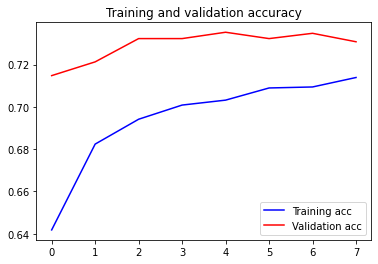

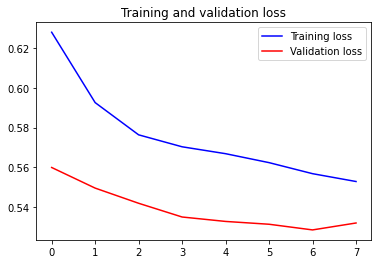

In [164]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [165]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [166]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [167]:
predict("I love the music")

1/1 [==============================] - 0s 328ms/step


{'label': 'POSITIVE',
 'score': 0.90464848279953,
 'elapsed_time': 0.3702421188354492}

In [168]:
predict("I hate the rain")

1/1 [==============================] - 0s 96ms/step


{'label': 'NEGATIVE',
 'score': 0.016466375440359116,
 'elapsed_time': 0.1320805549621582}

In [169]:
predict("i don't know what i'm doing")

1/1 [==============================] - 0s 98ms/step


{'label': 'NEUTRAL',
 'score': 0.5509347915649414,
 'elapsed_time': 0.1326005458831787}

In [170]:
print(df_test.target)

33553    4
9427     0
199      0
12447    0
39489    4
        ..
28567    4
25079    4
18707    0
15200    0
5857     0
Name: target, Length: 10000, dtype: int64


In [179]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
y_test_1d = [ "NEGATIVE" if y == 0 else "POSITIVE" if y == 4 else "NEUTRAL" for y in y_test_1d ]
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

2/2 [==============================] - 0s 114ms/step
CPU times: user 312 ms, sys: 0 ns, total: 312 ms
Wall time: 304 ms


In [173]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [ ]:
%%time
print(y_test_1d)
print(y_pred_1d)
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=labels, title="Confusion matrix")
plt.show()

In [182]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.76      0.70      0.73      5022
    POSITIVE       0.72      0.78      0.75      4978

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



In [183]:
accuracy_score(y_test_1d, y_pred_1d)

0.7401

In [184]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

In [185]:
from google.colab import files
files.download('/content/model.h5')
files.download('/content/model.w2v')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>